In [2]:
from unidepth.models import UniDepthV2
import torch
import numpy as np
import torch
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors

In [3]:
import json

with open('configs/config_v2_vits14.json') as f:
    config = json.load(f)

model = UniDepthV2(config)

In [4]:
model.load_state_dict(torch.load('checkpoint/latest.pth', map_location='cpu')['model'], strict=True)



<All keys matched successfully>

In [5]:

DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

model = model.to(DEVICE)

In [6]:
im_dir = "vis_depth/frame_02.jpg"

raw_img = Image.open(im_dir)
with torch.no_grad():
    rgb = torch.from_numpy(np.array(raw_img)).permute(2, 0, 1) # C, H, W

    predictions = model.infer(rgb)

    # Metric Depth Estimation
    depth = predictions["depth"]
    depth = depth.squeeze().to('cpu').numpy()

    # Point Cloud in Camera Coordinate
    xyz = predictions["points"]
    xyz = xyz.squeeze().to('cpu').numpy()

    # Intrinsics Prediction
    intrinsics = predictions["intrinsics"]


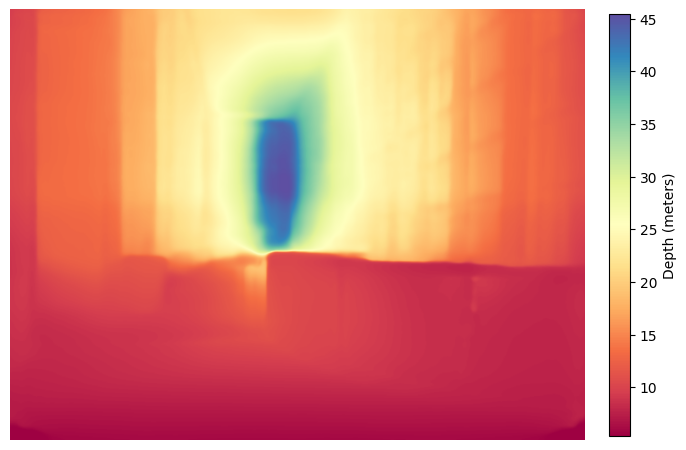

In [7]:
min_depth = depth.min()
max_depth = depth.max()

# Normalize the depth map
depth_normalized = (depth - min_depth) / (max_depth - min_depth)

# Apply colormap
cmap = plt.get_cmap('Spectral')
depth_color = (cmap(depth_normalized)[:, :, :3] * 255).astype(np.uint8)

# Visualize the depth map with colorbar
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis('off')  
img = ax.imshow(depth_color)

# Create colorbar
norm = matplotlib.colors.Normalize(vmin=min_depth, vmax=max_depth)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Adding colorbar below the image
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.034, pad=0.04)
cbar.set_label('Depth (meters)')

plt.show()

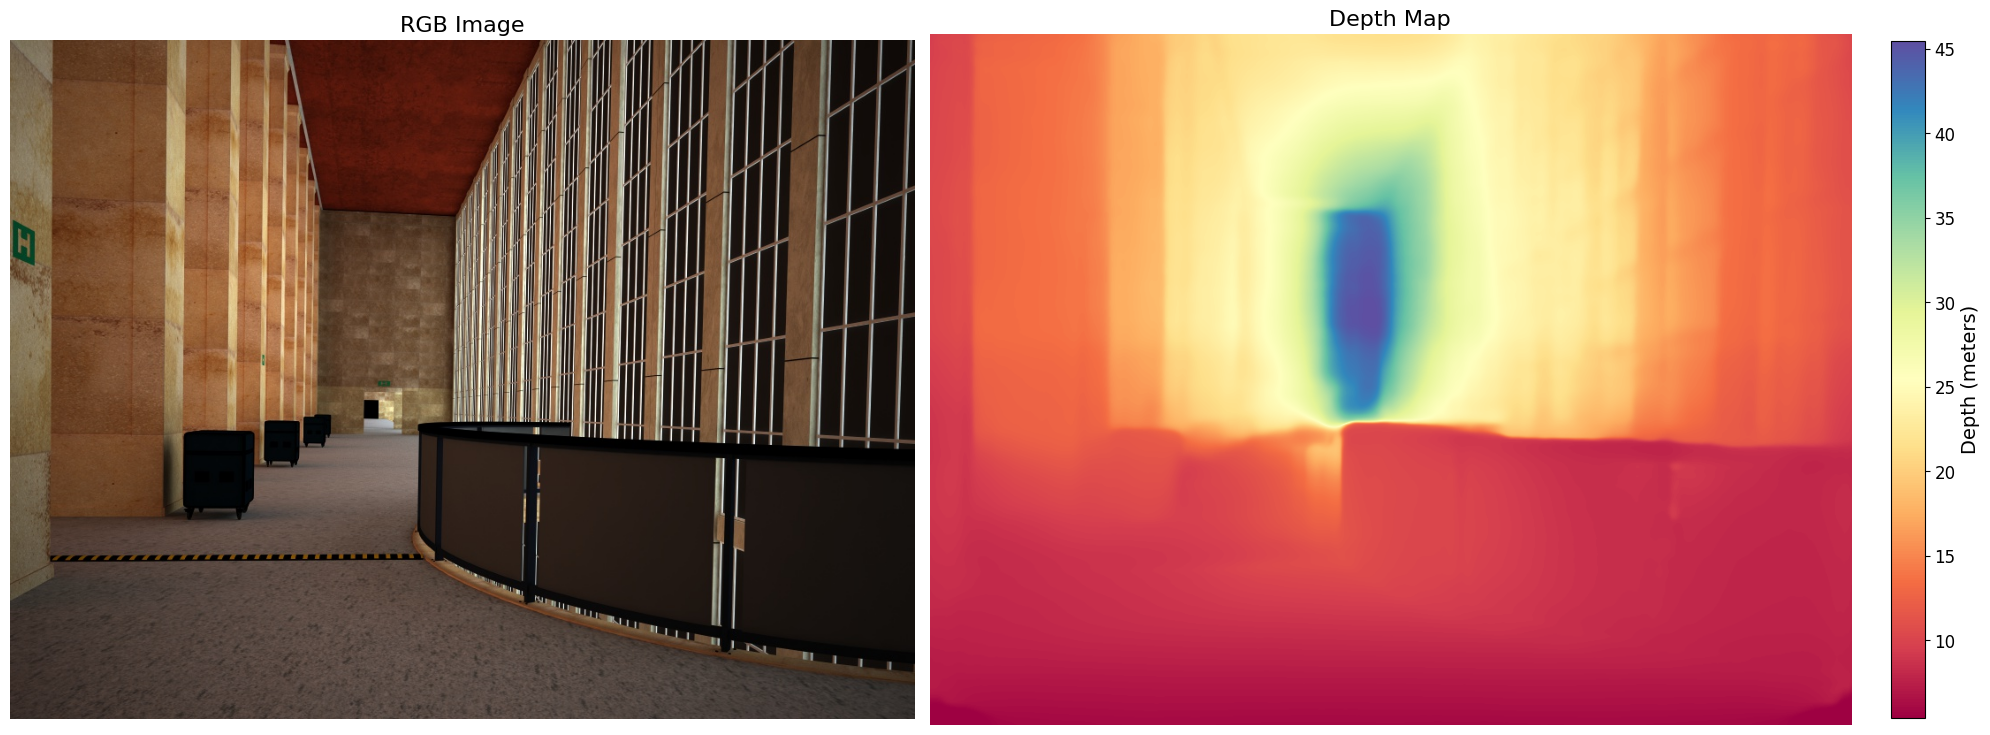

In [17]:
min_depth = depth.min()
max_depth = depth.max()

# Normalize the depth map
depth_normalized = (depth - min_depth) / (max_depth - min_depth)

# Apply colormap
cmap = plt.get_cmap('Spectral')
depth_color = (cmap(depth_normalized)[:, :, :3] * 255).astype(np.uint8)

# Create a figure with two subplots side by side, with the depth map larger
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={'width_ratios': [1, 1.1]})

# Plot RGB image
ax1.imshow(np.array(raw_img))
ax1.axis('off')
ax1.set_title('RGB Image', fontsize=16)

# Plot depth map
img = ax2.imshow(depth_color)
ax2.axis('off')
ax2.set_title('Depth Map', fontsize=16)

# Create colorbar
norm = matplotlib.colors.Normalize(vmin=min_depth, vmax=max_depth)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Adding colorbar to the right of the depth map
cbar = fig.colorbar(sm, ax=ax2, orientation='vertical', fraction=0.034, pad=0.04)
cbar.set_label('Depth (meters)', fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig('rgb_depth_comparison.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [22]:
np.save('xyz.npy', xyz)